# Top-down learning a GNN potential for coarse-grained water

In this notebook, we will learn a graph neural network (GNN) potential for coarse-grained water from experimental data.
The coarse-grained particle will represent the oxygen atom of atomistic water.
Analogous to the diamond example, we will directly apply the DiffTRe library without looking under its hood.
We define all components necessary to initialize DiffTRe: experimental data, simulation box, GNN potential with prior, simulator, loss function and optimizer.

In [1]:
from DiffTRe import io, difftre, custom_simulator, custom_quantity, custom_space, custom_energy
from jax_md import space, partition, simulate
import optax
import jax.numpy as jnp
from jax import device_get, random, jit, checkpoint, tree_util
import numpy as np
from scipy import interpolate as sci_interpolate
import matplotlib.pyplot as plt
from functools import partial
import time, pickle
import warnings
warnings.filterwarnings('ignore')  # disable warnings about float64 usage

energy_pickle_file_path = 'output/saved_models/CG_water_GNN.pkl'
optimization_pickle_file_path = 'output/saved_optimization_results/CG_water_optimization.pkl'
long_traj_pickle_file_path = 'output/saved_optimization_results/CG_water_long_traj.pkl'

### Experimental observables

Let's start by defining target observables. For top-down coarse-graining, we choose experimental data from the paper
_Quantum Differences between Heavy and Light Water_ [(Soper and Benmore, 2008)](https://doi.org/10.1103/PhysRevLett.101.065502).
Specifically, we want to match the oxygen-oxygen radial distribution function (RDF), the oxygen-oxygen-oxygen angular
distribution function (ADF), and a pressure of 1 bar.

In [2]:
pressure_conversion = 16.6054  # from kJ/mol nm^-3 to bar
pressure_target = 1. / pressure_conversion  # 1 bar in kJ / mol nm^3

# O-O RDF
rdf_bin_centers, rdf_bin_boundaries, sigma_RDF = custom_quantity.rdf_discretization(RDF_cut=1.0)  # cut RDF at 1nm
reference_rdf = np.loadtxt('data/experimental/O_O_RDF.csv')
rdf_spline = sci_interpolate.interp1d(reference_rdf[:, 0], reference_rdf[:, 1], kind='cubic')
reference_rdf = rdf_spline(rdf_bin_centers)
rdf_struct = custom_quantity.RDFParams(reference_rdf, rdf_bin_centers, rdf_bin_boundaries, sigma_RDF)

# O-O-O ADF
adf_bin_centers, sigma_ADF = custom_quantity.adf_discretization(nbins=200)
reference_adf = np.loadtxt('data/experimental/O_O_O_ADF.csv')
adf_spline = sci_interpolate.interp1d(reference_adf[:, 0], reference_adf[:, 1], kind='cubic')
reference_adf = adf_spline(adf_bin_centers)
# only triplets within 0.318 nm are considered, consistent with experimental data
adf_struct = custom_quantity.ADFParams(reference_adf, adf_bin_centers, sigma_ADF, r_outer=0.318, r_inner=0.)

target_dict = {'rdf': rdf_struct, 'adf': adf_struct, 'pressure': pressure_target}

### Simulation setup

Next, we define the simulation parameters.
Temperature and density are already determined by the experiment.

In [3]:
system_temperature = 296.15  # Kelvin = 23 deg. Celsius
Boltzmann_constant = 0.0083145107  # in kJ / mol K
kbT = system_temperature * Boltzmann_constant

file = 'data/confs/Water_experimental.gro'  # 901 particles
R_init, v, box = io.load_configuration(file)  # initial configuration
N = R_init.shape[0]

mass = 18.0154  # in u: O + 2 * H
density = mass * N * 1.66054 / jnp.prod(box)
print('Model Density:', density, 'g/l. Experimental density: 997.87 g/l')

# simulation times in ps
time_step = 0.002
total_time = 70. 
t_equilib = 10.  # equilibration time: skip states before sampling observables
print_every = 0.1  # save state every 0.1 ps for computation of averages
timings_struct = custom_simulator.process_printouts(time_step, total_time, t_equilib, print_every)

# define displacement and shift functions from box: 
# use periodic_general as we take derivatives wrt. box for pressure
R_init, box_tensor = custom_space.scale_to_fractional_coordinates(R_init, box)
displacement, shift = space.periodic_general(box_tensor)


Model Density: 998.28436 g/l. Experimental density: 997.87 g/l


### GNN Potential

Now we define the GNN as well as the prior potential. As our prior potential, we choose the repulsive part of the
Lennard-Jones (LJ) potential. As the prior length scale $\sigma$, we simply take the length scale of the LJ potential of the SPC water model $\sigma=0.3165$ nm and set the energy scale to $\epsilon = 1$ kJ / mol - reduced compared to the LJ potential as we neglect the attractive term.

Both potentials are combined by adding the computed potential energy values. The `energy` function that sums both potentials
is initialized by the `energy_fn_template`. The template enables updating GNN weights during optimization
without compromising "jitability". You can define your own custom `energy_fn_template` following the in- and output
signature shown below.

In [4]:
key = random.PRNGKey(0)  # define random seed for initialization of model and simulation
model_init_key, simuation_init_key = random.split(key, 2)

r_cut = 0.5

# create neighbor list
box_nbrs = jnp.ones(3)
neighbor_fn = partition.neighbor_list(displacement, box_nbrs, r_cut, dr_threshold=0.05, capacity_multiplier=1.5,
                                      disable_cell_list=True)
nbrs_init = neighbor_fn(R_init)

prior_fn = custom_energy.generic_repulsion_neighborlist(displacement, sigma=0.3165, epsilon=1., exp=12,
                                                         initialize_neighbor_list=False)

init_fn, GNN_energy = custom_energy.DimeNetPP_neighborlist(displacement, R_init, nbrs_init, r_cut)
init_params = init_fn(model_init_key, R_init, neighbor=nbrs_init)

def energy_fn_template(energy_params):
    gnn_energy = partial(GNN_energy, energy_params)
    def energy(R, neighbor, **dynamic_kwargs):
        return gnn_energy(R, neighbor=neighbor, **dynamic_kwargs) + prior_fn(R, neighbor=neighbor, **dynamic_kwargs)
    return jit(energy)

### Loss function

As some observables depend on the potential (e.g. the pressure in this case), we need the `energy_fn_template`
to define the loss function. `DiffTRe_init` builds a mean-squared-error (MSE) loss from a `quantity_dict`.
Building the `quantity_dict` requires to define for each observable $O_k(S_i, U_{\theta})$ a function to compute the respective
observable for each state $S_i$, the corresponding target value, and a scale $\gamma$ defining the relative importance
of each observable in the loss (see examples below).

In [5]:
quantity_dict = {}
if 'rdf' in target_dict:
    rdf_struct = target_dict['rdf']
    rdf_fn = custom_quantity.initialize_radial_distribution_fun(box_tensor, displacement, rdf_struct)
    rdf_dict = {'compute_fn': checkpoint(rdf_fn), 'target': rdf_struct.reference_rdf, 'gamma': 1.}
    quantity_dict['rdf'] = rdf_dict
if 'adf' in target_dict:
    adf_struct = target_dict['adf']
    adf_fn = custom_quantity.initialize_angle_distribution_neighborlist(displacement, adf_struct,
                                                                         R_init=R_init, nbrs_init=nbrs_init)
    adf_target_dict = {'compute_fn': checkpoint(adf_fn), 'target': adf_struct.reference_adf, 'gamma': 1.}
    quantity_dict['adf'] = adf_target_dict
if 'pressure' in target_dict:
    pressure_fn = custom_quantity.init_pressure(energy_fn_template, box_tensor)
    pressure_target_dict = {'compute_fn': checkpoint(pressure_fn), 'target': target_dict['pressure'], 'gamma': 1.e-7}
    quantity_dict['pressure'] = pressure_target_dict

### Simulator

Now we define the simulator used to generate reference trajectories.
Similar to the `energy_fn_template`, the `simulator_template` takes the current potential energy function
and returns a corresponding NVT simulator. This is achieved by simply "baking in" all constant
simulation parameters via `partial`. For this example, we select a Nose-Hoover thermostat with a chain length of 5.
With a given simulator, we generate the initial simulation state from which the first trajectory is sampled.

In [6]:
energy_fn_init = energy_fn_template(init_params)
simulator_template = partial(simulate.nvt_nose_hoover, shift_fn=shift, dt=time_step, kT=kbT,
                             chain_length=5, chain_steps=1)
init, _ = simulator_template(energy_fn_init)
state = init(simuation_init_key, R_init, mass=mass, neighbor=nbrs_init)
init_sim_state = (state, nbrs_init)

### Optimizer

We use an Adam optimizer with exponential learning rate decay.

In [7]:
num_updates = 300
initial_lr = 0.003
lr_schedule = optax.exponential_decay(-initial_lr, 200, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule)
)


### Initialize DiffTRe

With all individual components defined, we can initialize DiffTRe. `update_fn` can be called iteratively to update potential parameters using the whole DiffTRe
pipeline. `trajectory_state` is the initial reference trajectory.

In [8]:
simulation_funs = (simulator_template, energy_fn_template, neighbor_fn)
update_fn, trajectory_state = difftre.DiffTRe_init(simulation_funs, timings_struct, quantity_dict, kbT,
                                                   init_params, init_sim_state, optimizer)

Time for a single trajectory generation: 8.614710903167724 mins


### Learning the GNN potential

The optimization takes several hours. You can skip it and load the trained model in the next cell.

In [9]:
loss_history, times_per_update, predicted_quantities = [], [], []

params = init_params
opt_state = optimizer.init(init_params)  # initialize optimizer state
for step in range(num_updates):
    start_time = time.time()
    params, opt_state, trajectory_state, loss_val, predictions = update_fn(step, params, opt_state, trajectory_state)
    loss_val.block_until_ready()
    step_time = time.time() - start_time

    times_per_update.append(step_time)
    loss_history.append(loss_val)
    predicted_quantities.append(predictions)
    print("Step {} in {:0.2f} sec".format(step, step_time), 'Loss = ', loss_val, '\n')

    if jnp.isnan(loss_val):  # stop learning when optimization diverged
        print('Loss is NaN. This was likely caused by divergence of the optimization or a bad model setup '
              'causing a NaN trajectory.')
        break

# save optimized energy_params for re-use
final_energy_params = device_get(params)
with open(energy_pickle_file_path, 'wb') as f:
    pickle.dump(final_energy_params, f)

with open(optimization_pickle_file_path, 'wb') as f:
    pickle.dump([loss_history, times_per_update, predicted_quantities], f)

Step 0 in 197.84 sec Loss =  0.20652293 

Step 1 in 475.50 sec Loss =  0.13125692 

Step 2 in 474.20 sec Loss =  0.07863852 

Step 3 in 479.85 sec Loss =  0.07812308 

Step 4 in 483.52 sec Loss =  0.047913007 

Step 5 in 485.52 sec Loss =  0.054071058 

Step 6 in 482.47 sec Loss =  0.059631474 

Step 7 in 480.00 sec Loss =  0.051203515 

Step 8 in 481.23 sec Loss =  0.033106655 

Step 9 in 479.51 sec Loss =  0.027202435 

Step 10 in 477.53 sec Loss =  0.03200091 

Step 11 in 481.09 sec Loss =  0.03532456 

Step 12 in 478.91 sec Loss =  0.027383335 

Step 13 in 480.51 sec Loss =  0.033903237 

Step 14 in 479.52 sec Loss =  0.019776609 

Step 15 in 481.21 sec Loss =  0.014330059 

Step 16 in 479.42 sec Loss =  0.014183459 

Step 17 in 481.54 sec Loss =  0.030751463 

Step 18 in 479.45 sec Loss =  0.013344357 

Step 19 in 481.40 sec Loss =  0.01764655 

Step 20 in 479.50 sec Loss =  0.009800416 

Step 21 in 479.90 sec Loss =  0.01282771 

Step 22 in 477.49 sec Loss =  0.019375578 

Step 2

Step 181 in 480.39 sec Loss =  0.00017813173 

Step 182 in 473.36 sec Loss =  0.00017337949 

Step 183 in 473.65 sec Loss =  0.00018198017 

Step 184 in 476.38 sec Loss =  0.00017649896 

Step 185 in 475.71 sec Loss =  0.00017226409 

Step 186 in 475.78 sec Loss =  0.0001762662 

Step 187 in 475.19 sec Loss =  0.0001641068 

Step 188 in 41.32 sec Loss =  0.00016386923 

Step 189 in 41.37 sec Loss =  0.00016927878 

Step 190 in 41.43 sec Loss =  0.00016646825 

Step 191 in 41.38 sec Loss =  0.00016268148 

Step 192 in 41.39 sec Loss =  0.00016241639 

Step 193 in 41.39 sec Loss =  0.00016264248 

Step 194 in 41.38 sec Loss =  0.00016254293 

Step 195 in 41.39 sec Loss =  0.00016083989 

Step 196 in 475.15 sec Loss =  0.00016606993 

Step 197 in 475.79 sec Loss =  0.00016066925 

Step 198 in 474.81 sec Loss =  0.00018024849 

Step 199 in 41.35 sec Loss =  0.0001731702 

Step 200 in 41.39 sec Loss =  0.00017110494 

Step 201 in 41.39 sec Loss =  0.00017007117 

Step 202 in 41.48 sec Loss 

In [10]:
# load results if necessary
final_energy_params = pickle.load(open(energy_pickle_file_path, "rb" ))
final_energy_params = tree_util.tree_map(jnp.array, final_energy_params)
loss_history, times_per_update, predicted_quantities = pickle.load(open(optimization_pickle_file_path, "rb" ))

## Visualize training process

To assess convergence, we can visualize the loss and compute-time per update. In the beginning, recomputation of the reference trajectory is necessary at each update, due to large parameter updates. Later, with decreased step sizes, reference
trajectories can be re-used frequently, resulting in a significant speed-up as only the reweighting step and the gradient
need to be computed.

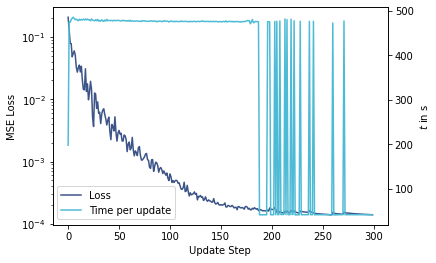

In [11]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Update Step')
ax1.set_ylabel('MSE Loss')
ax1.semilogy(loss_history, color='#3c5488ff', label='Loss')
ax2 = ax1.twinx()
ax2.plot(times_per_update, label='Time per update', color='#4dbbd5ff')
ax2.set_ylabel('$t$ in s')
fig.legend(loc="upper right", bbox_to_anchor=(0.38,0.2), bbox_transform=ax1.transAxes)
plt.savefig('Train_history_CG_water.png')
plt.show()

Next, we visualize convergence of target observables.

Pressure final epoch: 2.4268165 kJ / mol nm^3


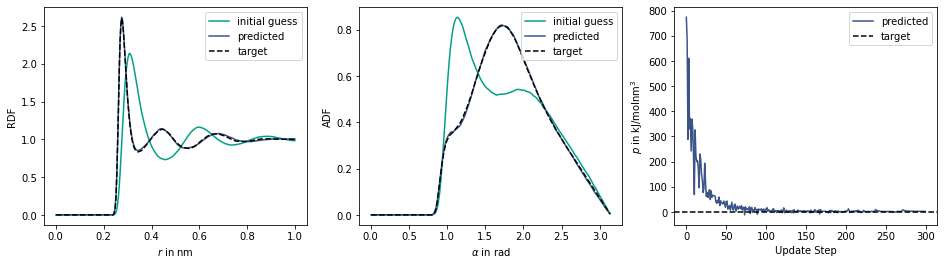

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

if 'rdf' in predicted_quantities[0]:
    rdf_series = [prediction_dict['rdf'] for prediction_dict in predicted_quantities]

    ax1.set_xlabel('$r$ in nm')
    ax1.set_ylabel('RDF')
    ax1.plot(rdf_bin_centers, rdf_series[0], label='initial guess', color='#00a087ff')
    ax1.plot(rdf_bin_centers, rdf_series[-1], label='predicted', color='#3c5488ff')
    ax1.plot(rdf_bin_centers, reference_rdf, label='target', linestyle='--', color='k')
    ax1.legend()


if 'adf' in predicted_quantities[0]:
    adf_series = [prediction_dict['adf'] for prediction_dict in predicted_quantities]

    ax2.set_xlabel(r'$\alpha$ in rad')
    ax2.set_ylabel('ADF')
    ax2.plot(adf_bin_centers, adf_series[0], label='initial guess', color='#00a087ff')
    ax2.plot(adf_bin_centers, adf_series[-1], label='predicted', color='#3c5488ff')
    ax2.plot(adf_bin_centers, reference_adf, label='target', linestyle='--', color='k')
    ax2.legend(loc=1)

if 'pressure' in predicted_quantities[0]:
    pressure_series = [prediction_dict['pressure'] for prediction_dict in predicted_quantities]

    ax3.set_xlabel('Update Step')
    ax3.set_ylabel('$p$ in $\mathrm{kJ / mol nm^3}$')
    ax3.plot(pressure_series, label='predicted', color='#3c5488ff')
    ax3.axhline(y=pressure_target, linestyle='--', color='k', label='target')
    ax3.legend()
    print('Pressure final epoch:', pressure_series[-1], 'kJ / mol nm^3')

plt.savefig('Predicted_CG_water_properties.png')
plt.show()

## Validate results

Given that we've trained the model on rather short trajectories, let's validate the model on a longer trajectory.
This allows to detect if the model overfitted to initial conditions or drifts away from the targets.

In [13]:
total_time_long = 11000.  # 11 ns
t_equilib_long = 1000.  # 1 ns
long_trajectory_struct = custom_simulator.process_printouts(time_step, total_time_long, t_equilib_long, print_every)

trajectory_generator = difftre.trajectory_generator_init(simulation_funs, long_trajectory_struct)
long_traj_state = trajectory_generator(final_energy_params, init_sim_state)
quantity_traj = difftre.compute_quantity_traj(long_traj_state, quantity_dict, neighbor_fn, final_energy_params)

long_traj_rdf = jnp.mean(quantity_traj['rdf'], axis=0)
long_traj_adf = jnp.mean(quantity_traj['adf'], axis=0)
long_traj_press = jnp.mean(quantity_traj['pressure'], axis=0)

with open(long_traj_pickle_file_path, 'wb') as f:
    pickle.dump([long_traj_rdf, long_traj_adf, long_traj_press], f)

In [14]:
# you can skip the long run above and just load results
long_traj_rdf, long_traj_adf, long_traj_press = pickle.load(open(long_traj_pickle_file_path, "rb" ))

Comparing results from the long trajectory with our targets confirms that training was successful.

Prediced pressure: 0.7751365 kJ / mol nm^3; Target: 0.060221373769978444 kJ / mol nm^3


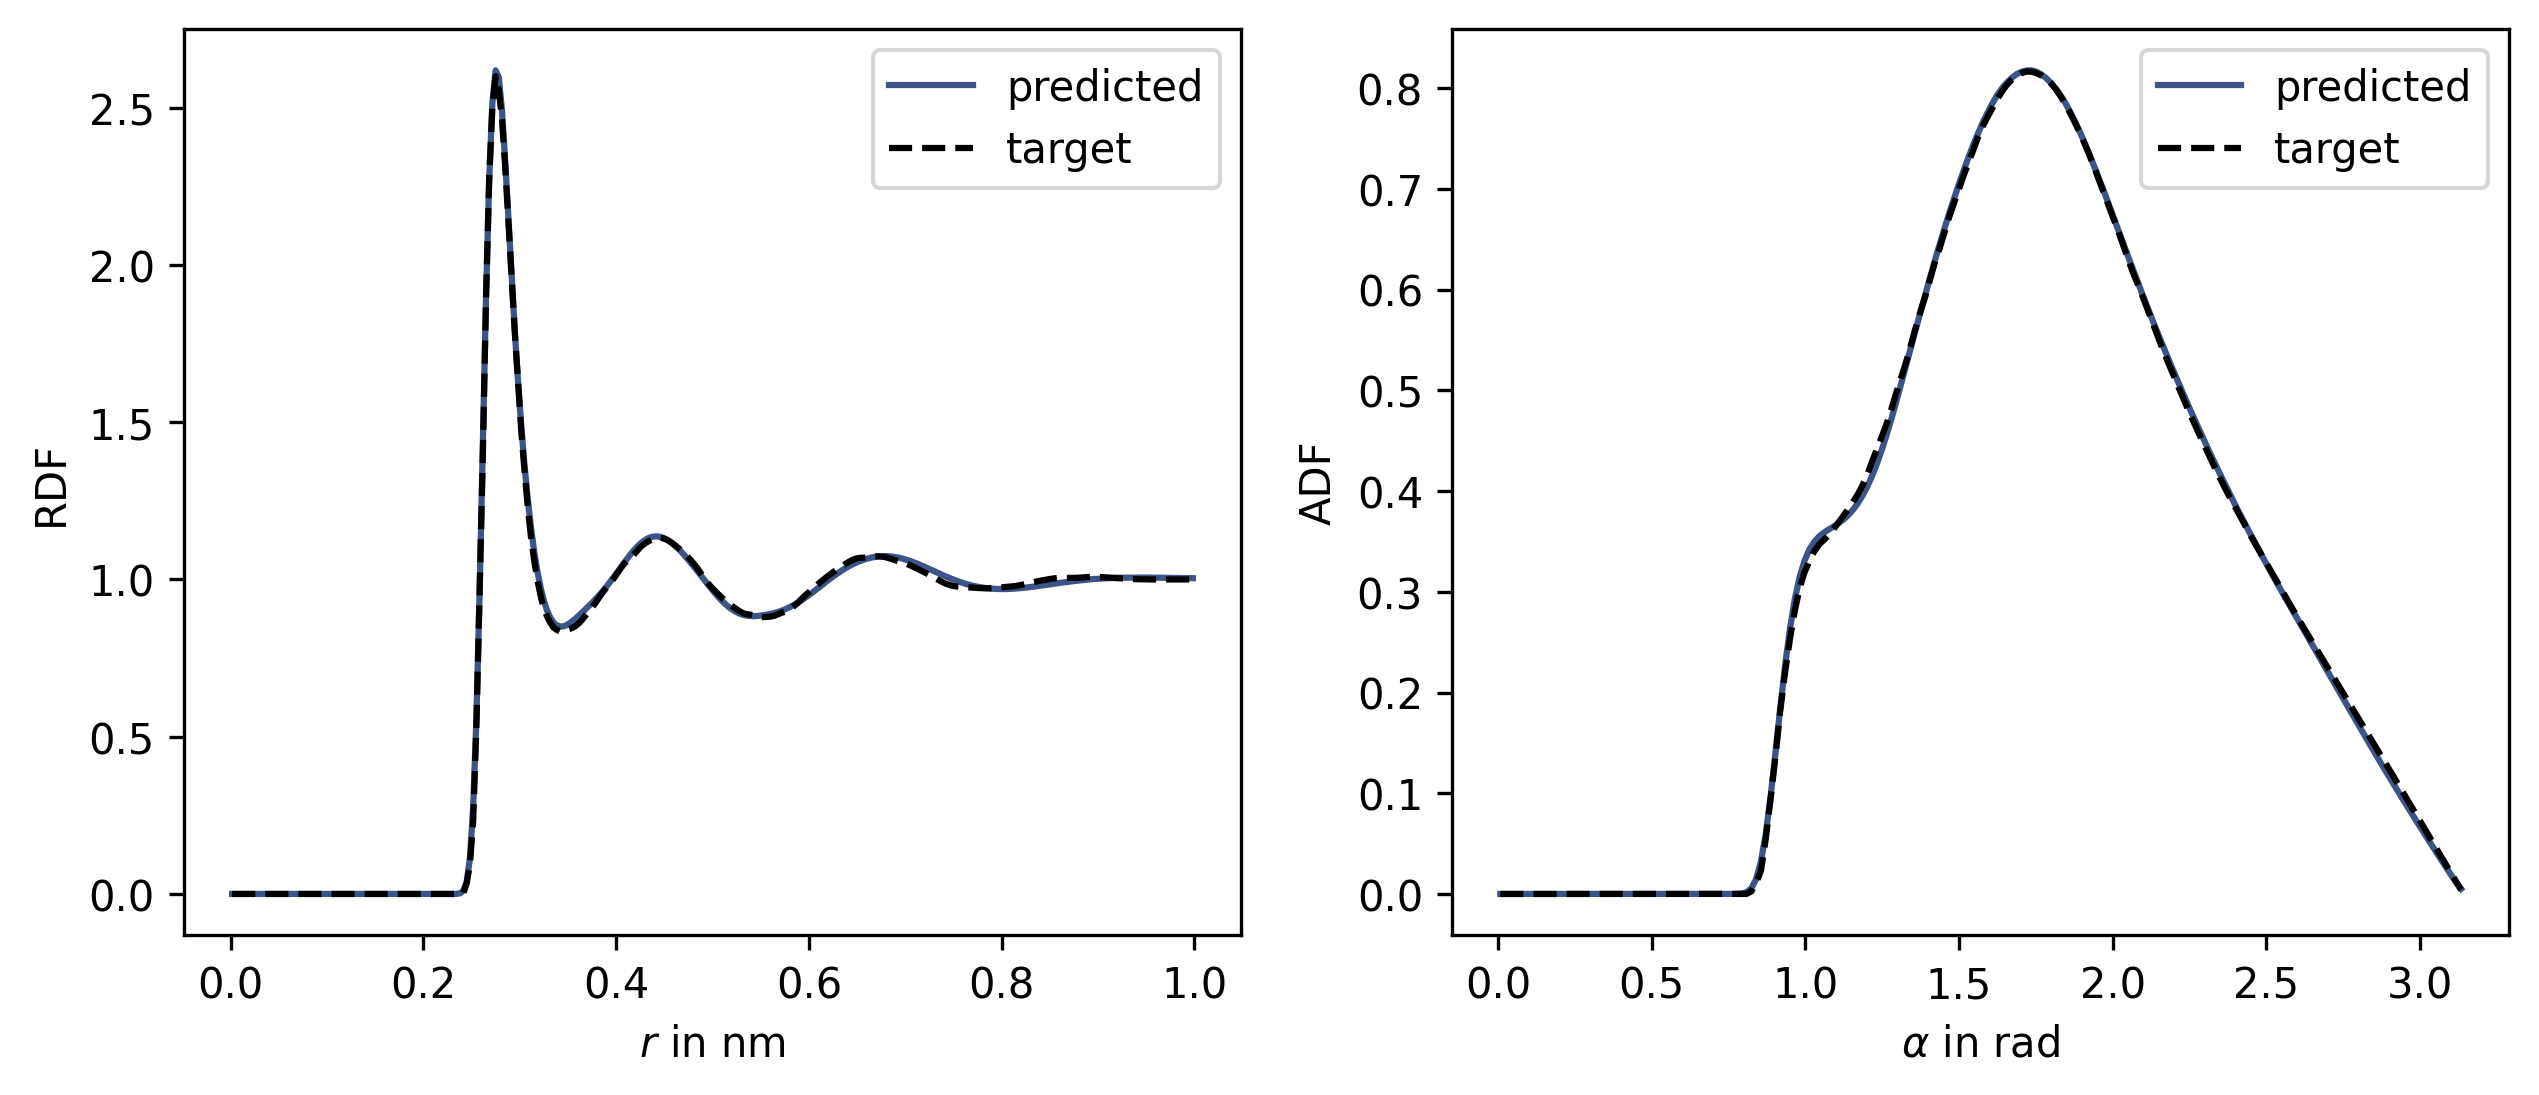

In [15]:
print('Prediced pressure:', long_traj_press, 'kJ / mol nm^3; Target:', pressure_target, 'kJ / mol nm^3')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

ax1.set_xlabel('$r$ in nm')
ax1.set_ylabel('RDF')
ax1.plot(rdf_bin_centers, long_traj_rdf, label='predicted', color='#3c5488ff')
ax1.plot(rdf_bin_centers, reference_rdf, label='target', linestyle='--', color='k')
ax1.legend()

ax2.set_xlabel(r'$\alpha$ in rad')
ax2.set_ylabel('ADF')
ax2.plot(adf_bin_centers, long_traj_adf, label='predicted', color='#3c5488ff')
ax2.plot(adf_bin_centers, reference_adf, label='target', linestyle='--', color='k')
ax2.legend(loc=1)

plt.savefig('Predicted_water_properties_long_traj.png')
plt.show()
